<h1>CREAZIONE MODELLO SARIMA REGIONE PUGLIA

In [243]:
import pandas as pd
df = pd.read_csv('../../csv/regioni/puglia.csv')
df.head()

,DATA,TOTALE
0,2015-01-31,4100
1,2015-02-28,3432
2,2015-03-31,3512
3,2015-04-30,3189
4,2015-05-31,3018


In [244]:
df['DATA'] = pd.to_datetime(df['DATA'])

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    66 non-null     datetime64[ns]
 1   TOTALE  66 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.2 KB


In [246]:
df=df.set_index('DATA')
df.head()

,TOTALE
DATA,
2015-01-31,4100
2015-02-28,3432
2015-03-31,3512
2015-04-30,3189
2015-05-31,3018


<h3>Creazione serie storica dei decessi totali della regione Puglia

In [247]:
ts = df.TOTALE
ts.head()

DATA
2015-01-31    4100
2015-02-28    3432
2015-03-31    3512
2015-04-30    3189
2015-05-31    3018
Name: TOTALE, dtype: int64

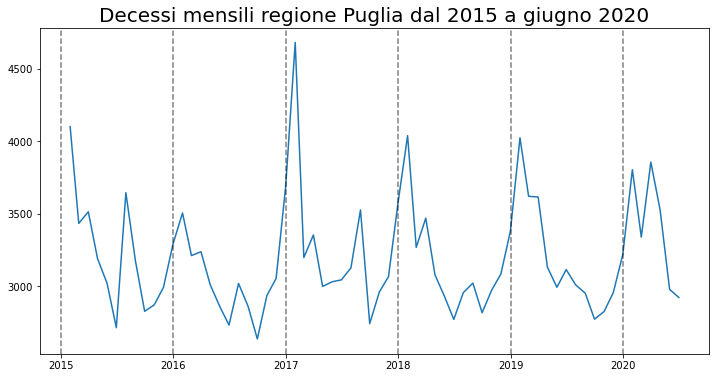

In [248]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,6,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi mensili regione Puglia dal 2015 a giugno 2020', size=20)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h3>Decomposizione

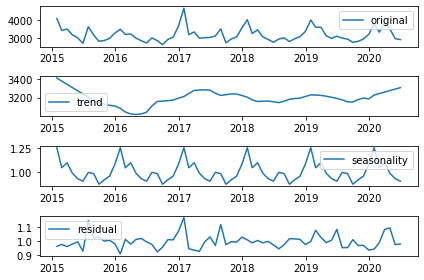

In [249]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h3>Test di stazionarietà

In [250]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False
        

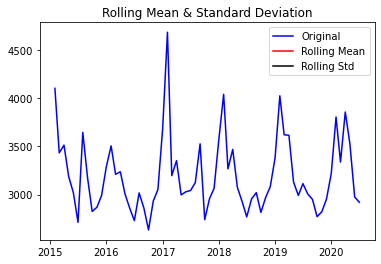

Results of Dickey-Fuller Test:
Test Statistic                 -5.384721
p-value                         0.000004
#Lags Used                      0.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64
X is stationary


True

In [251]:
test_stationarity(ts)

<h3>Suddivisione in Train e Test

<b>Train</b>: da gennaio 2015 a ottobre 2019; <br />
<b>Test</b>: da ottobre 2019 a dicembre 2019.

In [252]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,6,30)

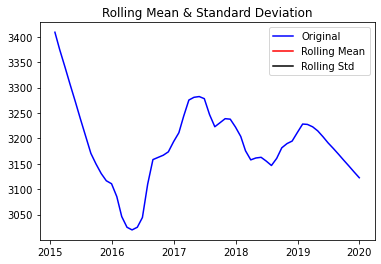

Results of Dickey-Fuller Test:
Test Statistic                 -3.581908
p-value                         0.006116
#Lags Used                      9.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64
X is not stationary


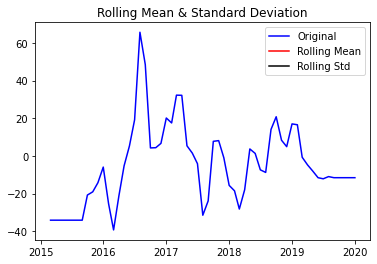

Results of Dickey-Fuller Test:
Test Statistic                 -2.869007
p-value                         0.049073
#Lags Used                     10.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64
X is not stationary


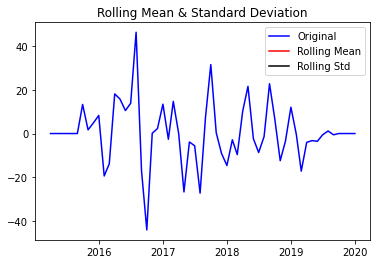

Results of Dickey-Fuller Test:
Test Statistic                 -2.698784
p-value                         0.074249
#Lags Used                      6.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
X is not stationary


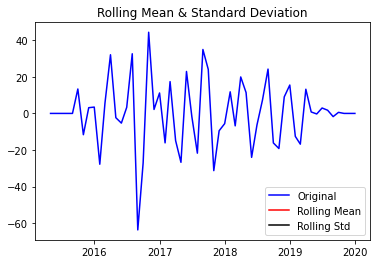

Results of Dickey-Fuller Test:
Test Statistic                 -4.988099
p-value                         0.000023
#Lags Used                      8.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64
X is stationary
3


In [254]:
from dateutil.relativedelta import *
tsb = ts[:test_end]
decomposition = seasonal_decompose(tsb, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

tsb_trend = decomposition.trend #andamento della curva
tsb_seasonal = decomposition.seasonal #stagionalità 
tsb_residual = decomposition.resid #parti rimanenti


tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1
print(d)

#TEST: dal 01-01-2015 al 31-10-2019
train = tsb[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = tsb[train_end + relativedelta(months=+1): test_end]

<h3>Grafici di Autocorrelazione eAutocorrelazione Parziale

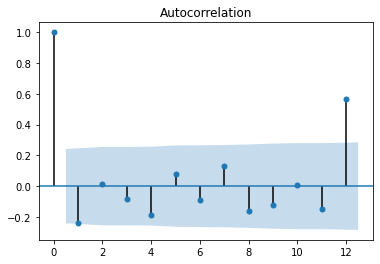

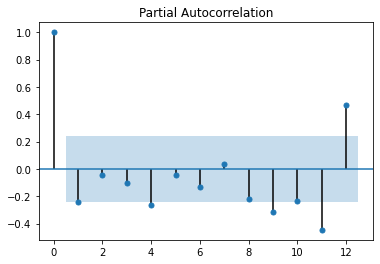

In [255]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_diff, lags =12)
plot_pacf(ts_diff, lags =12)
plt.show()

<h2>Creazione del modello SARIMA sul Train

In [256]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(12,0,8))
model_fit = model.fit()
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

                               SARIMAX Results                                
Dep. Variable:                 TOTALE   No. Observations:                   58
Model:              SARIMAX(12, 0, 8)   Log Likelihood                -407.756
Date:                Sun, 15 Nov 2020   AIC                            857.512
Time:                        18:00:56   BIC                            900.782
Sample:                    01-31-2015   HQIC                           874.366
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1487      0.094      1.582      0.114      -0.035       0.333
ar.L2          0.0213      0.113      0.188      0.851      -0.201       0.243
ar.L3         -0.0148      0.120     -0.124      0.9

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<h4>Verifica della stazionarietà dei residui del modello ottenuto

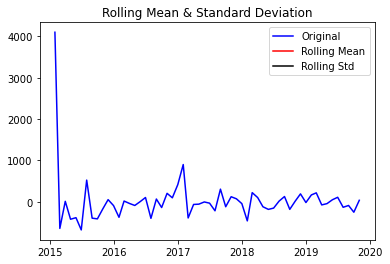

Results of Dickey-Fuller Test:
Test Statistic                -19.758450
p-value                         0.000000
#Lags Used                      0.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64
X is stationary


True

In [257]:
residuals = model_fit.resid
test_stationarity(residuals)

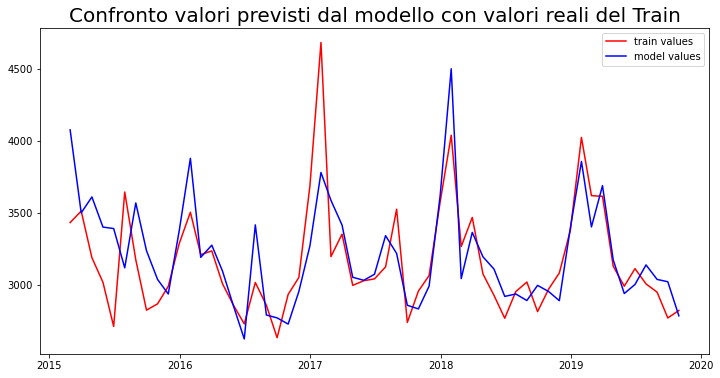

In [258]:
plt.figure(figsize=(12,6))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red', label='train values')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue', label='model values')

plt.legend()
plt.show()

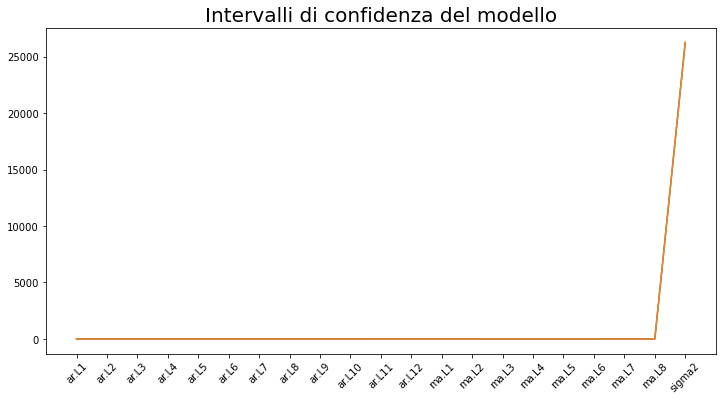

In [259]:
conf = model_fit.conf_int()

plt.figure(figsize=(12,6))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h3>Predizione del modello sul Test

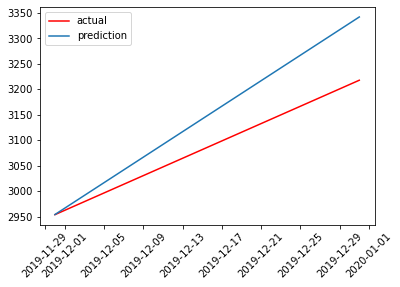

2019-11-30    2954.211046
2019-12-31    3342.213974
Freq: M, Name: predicted_mean, dtype: float64


In [260]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]

#pred_start= len(train)
#pred_end = len(tsb)
#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)

plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(predictions_test)

<h3>Calcolo dell'indice RMSE

In [261]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.3326995074945466


<h2>Predizione del modello compreso l'anno 2020

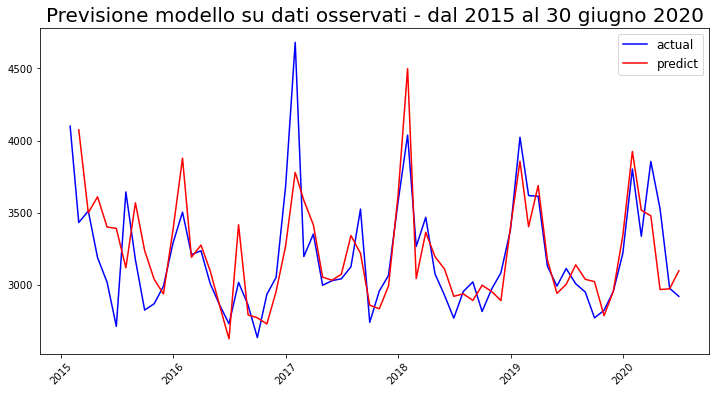

In [262]:
#inizio e fine predizione
start_prediction = ts_diff.index[0]
end_prediction = ts_diff.index[-1]

predictions_tot = model_fit.predict(start=start_prediction, end=end_prediction)

plt.figure(figsize=(12,6))
plt.title('Previsione modello su dati osservati - dal 2015 al 30 giugno 2020', size=20)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

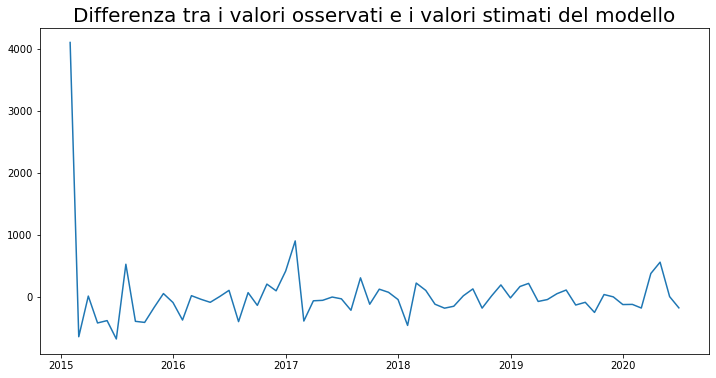

In [263]:
diff_predictions_tot = (ts - predictions_tot)
plt.figure(figsize=(12,6))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot)
plt.show()

In [264]:
diff_predictions_tot['24-02-2020':].sum()

581.0597189623086

In [265]:
predictions_tot.to_csv('../../csv/pred/predictions_SARIMA_puglia.csv')

<h2>Intervalli di confidenza della previsione totale

In [266]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int()
print(forecast.predicted_mean)
print(in_c)
print(forecast.predicted_mean - in_c['lower TOTALE'])

2015-01-31       0.000000
2015-02-28    4074.929176
2015-03-31    3499.704423
2015-04-30    3609.952430
2015-05-31    3400.897639
                 ...     
2020-02-29    3517.231151
2020-03-31    3478.558183
2020-04-30    2967.342626
2020-05-31    2972.298412
2020-06-30    3097.509910
Freq: M, Name: predicted_mean, Length: 66, dtype: float64
            lower TOTALE  upper TOTALE
2015-01-31  -6900.444370   6900.444370
2015-02-28   3312.991406   4836.866947
2015-03-31   2744.105839   4255.303008
2015-04-30   2867.800368   4352.104492
2015-05-31   2684.515341   4117.279937
...                  ...           ...
2020-02-29   3118.815149   3915.647152
2020-03-31   3079.115660   3878.000705
2020-04-30   2561.615967   3373.069285
2020-05-31   2560.728356   3383.868468
2020-06-30   2623.583090   3571.436729

[66 rows x 2 columns]
2015-01-31    6900.444370
2015-02-28     761.937771
2015-03-31     755.598584
2015-04-30     742.152062
2015-05-31     716.382298
                 ...     
2020-02-2

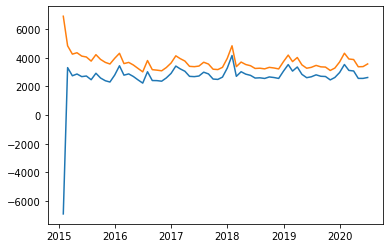

In [267]:
plt.plot(in_c)
plt.show()

In [268]:
upper = in_c['upper TOTALE']
lower = in_c['lower TOTALE']

In [269]:
lower.to_csv('../../csv/lower/predictions_SARIMA_puglia_lower.csv')
upper.to_csv('../../csv/upper/predictions_SARIMA_puglia_upper.csv')